# Previsão de Preços de Ações com LSTM
Este notebook compara dois modelos de LSTM para previsão de ações da Apple (AAPL):
- Um modelo **univariado**, usando apenas o preço de fechamento
- Um modelo **multivariado**, usando preço de abertura, fechamento, máxima, mínima e volume

As métricas de avaliação incluem: **MAPE**, **MAE** e **RMSE**

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

plt.style.use("ggplot")


2025-06-29 11:35:59.033865: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 11:35:59.037109: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 11:35:59.046714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751207759.064391   16002 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751207759.069588   16002 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751207759.082424   16002 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## 1. Coleta de Dados

In [2]:
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # remove 'Ticker'
data.columns.name = None
data = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
data.tail()


/tmp/ipykernel_16002/542923656.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2024-12-23,254.156919,255.034791,252.840088,254.655716,40858800
2024-12-24,254.875189,257.588630,254.675658,257.578674,23234700
2024-12-26,257.568678,259.474086,257.010028,258.396667,27237100
2024-12-27,257.209530,258.077462,252.451019,254.974930,42355300
2024-12-30,251.623005,252.889953,250.146571,251.593079,35557500


## 2. Normalização dos Dados

In [3]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled, columns=data.columns, index=data.index)


## 3. Criação das Janelas de Tempo

In [4]:
def create_sequences(dataset, target_col, lookback=60):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i - lookback:i])
        y.append(dataset[i, target_col])
    return np.array(X), np.array(y)


## 4. Preparação dos Dados para os Modelos

In [5]:
lookback = 60
target_col = data.columns.get_loc("Close")

# Univariado
close_only = scaled_data[['Close']].values
X_uni, y_uni = create_sequences(close_only, 0, lookback)
X_uni = X_uni.reshape((X_uni.shape[0], X_uni.shape[1], 1))

# Multivariado
X_multi, y_multi = create_sequences(scaled, target_col, lookback)

# Divisão treino/teste
split = int(0.8 * len(X_uni))
X_uni_train, X_uni_test = X_uni[:split], X_uni[split:]
y_uni_train, y_uni_test = y_uni[:split], y_uni[split:]

X_multi_train, X_multi_test = X_multi[:split], X_multi[split:]
y_multi_train, y_multi_test = y_multi[:split], y_multi[split:]


In [6]:
target_col

3

## 5. Treinamento dos Modelos

In [7]:
def build_and_train(X_train, y_train, X_val, y_val):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    return model


In [8]:
model_uni = build_and_train(X_uni_train, y_uni_train, X_uni_test, y_uni_test)
model_multi = build_and_train(X_multi_train, y_multi_train, X_multi_test, y_multi_test)


2025-06-29 11:36:02.037325: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/kunumi/Documents/Pessoal/pos/fiap_fase4/.venv_fase4/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6. Avaliação dos Modelos

In [9]:
pred_uni = model_uni.predict(X_uni_test)
pred_multi = model_multi.predict(X_multi_test)

# Inverter escala
close_index = data.columns.get_loc('Close')

# Recuperar o número total de colunas após normalização
n_features = scaled.shape[1]
# Função auxiliar para reconstruir o vetor original com apenas a coluna "Close" preenchida
def reintegrate_column(column_values, column_index, total_columns):
    zeros_before = np.zeros((len(column_values), column_index))
    zeros_after = np.zeros((len(column_values), total_columns - column_index - 1))
    return np.concatenate([zeros_before, column_values.reshape(-1, 1), zeros_after], axis=1)

# Inverter a escala para os valores reais e previstos
actual = scaler.inverse_transform(reintegrate_column(y_uni_test, close_index, n_features))[:, close_index]
pred_uni_inv = scaler.inverse_transform(reintegrate_column(pred_uni, close_index, n_features))[:, close_index]
pred_multi_inv = scaler.inverse_transform(reintegrate_column(pred_multi, close_index, n_features))[:, close_index]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [13]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Univariado:")
print("MAE:", mean_absolute_error(actual, pred_uni_inv))
print("RMSE:", root_mean_squared_error(actual, pred_uni_inv))
print("MAPE:", mape(actual, pred_uni_inv))

print("\nMultivariado:")
print("MAE:", mean_absolute_error(actual, pred_multi_inv))
print("RMSE:", root_mean_squared_error(actual, pred_multi_inv))
print("MAPE:", mape(actual, pred_multi_inv))


Univariado:
MAE: 5.3013776504297825
RMSE: 6.589619751941848
MAPE: 2.5319446741439324

Multivariado:
MAE: 4.737401788431296
RMSE: 5.916415406261108
MAPE: 2.233476228786515


## 7. Comparação Visual

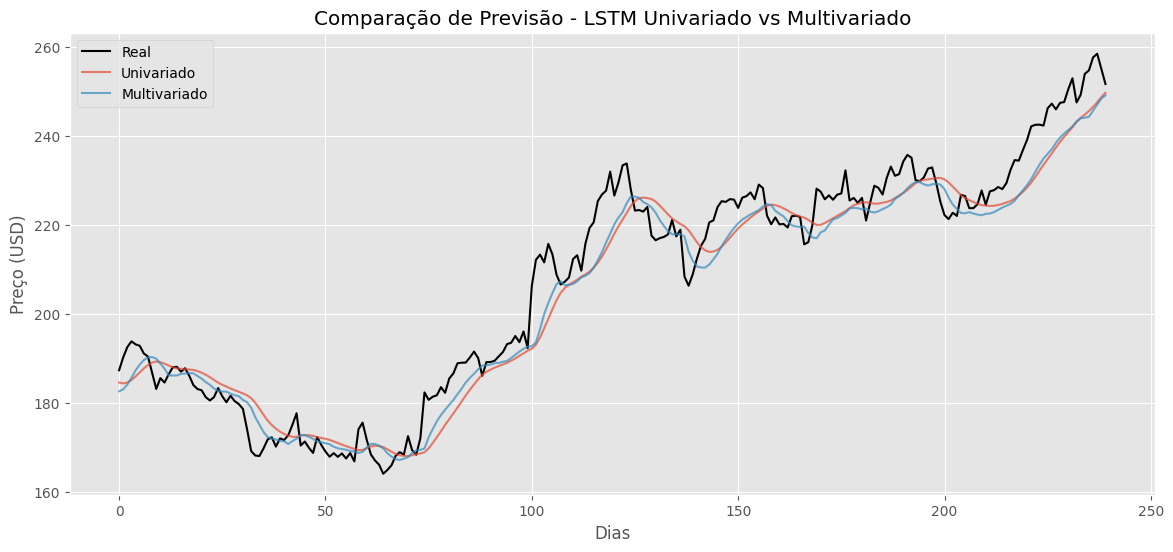

In [14]:
plt.figure(figsize=(14,6))
plt.plot(actual, label="Real", color="black")
plt.plot(pred_uni_inv, label="Univariado", alpha=0.7)
plt.plot(pred_multi_inv, label="Multivariado", alpha=0.7)
plt.title("Comparação de Previsão - LSTM Univariado vs Multivariado")
plt.xlabel("Dias")
plt.ylabel("Preço (USD)")
plt.legend()
plt.show()
